In [27]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from typing import List
from enum import Enum

In [34]:
"""
Using Jetbrains DataSpell IDE inverts the color of grayscale images
when plotting using matplotlib, change this variable to false if you
are using Google Colab, VS Code or any other IDE
"""
INVERTED_IMG_COLOR = True

"""
Helper method to handle the plotting of an image using matplotlib
"""
def plot(img: List[List]):
    stg = img.copy()
    if INVERTED_IMG_COLOR:
        for i in range(len(img)):
            for j in range(len(img[0])):
                stg[i, j] = 255 - stg[i, j]
    plt.imshow(stg, cmap="gray", vmin=0, vmax=255)
    plt.show()

"""
Helper method to print multiple small images side to side
"""
def plot_multiple(img: List[List[List]]):
    size, w, h = len(img), [], []

    super_img = []

    if size == 0:
        return

    for i in range(size):
        h.append(len(img[i]))
        w.append(len(img[i][0]))

    for i in range(max(h)):
        super_img.append([])
        for j in range(size):
            if i < h[j]:
                super_img[i].extend(img[j][i])
            else:
                super_img[i].extend([0] * w[j])

    plot(np.array(super_img))

# Transformación morfologica de dilatación

La dilatación en el procesamiento de imagenes digitales se trata de un proceso opuesto a la erosión, en el que se pretende expandir o alargar la figura de un objecto en vez de hacerlo lucir más pequeño o delgado. Este procesamiento se puede utilizar para reducir las brechas o el ruido existente en una imagen y de esta manera mejorar la calidad de la imagen (Davies, 2018).

Referencias:

Davies, E.R. (2018) Computer vision: Principles, algorithms, applications, learning. London: Academic Press.

In [29]:
"""
Enumeration of the color spaces, so we can pass to the method
to identify if working with a binary or grayscale image
"""
class ColorSpace(Enum):
    BlackAndWhite=1
    Grayscale=2

"""
Enumeration to define different structures that can be used with the
dilation method. 0 values are not considered part of the neighborhood.
"""
class Structure(Enum):

    s3x3 = [
        [0,1,0],
        [1,1,1],
        [0,1,0]
    ]

    s5x5 = [
        [0,0,1,0,0],
        [0,1,1,1,0],
        [1,1,1,1,1],
        [0,1,1,1,0],
        [0,0,1,0,0]
    ]

    s1x3 = [
        [1,1,1]
    ]

    s3x1 = [
        [1],
        [1],
        [1]
    ]

    """
    Method to obtain the structure for the specific color space, this mean that
    for grayscale images we should return 255 or 0 while binary images expect 1 or 0.
    """
    def in_color_space(self, color_space:ColorSpace = ColorSpace.Grayscale):
        val = 255
        if color_space == ColorSpace.BlackAndWhite:
            val = 1
        return np.multiply(self.value, val)

"""
Method to add padding to an image on the borders. By default the padding
value is 0.
"""
def add_padding(img: List[List], padding_h: int, padding_w: int, value: int = 0) -> List[List]:
    w = len(img[0])
    h = len(img)
    padded_img = []

    # Vertical padding
    for i in range(padding_h):
        padded_img.append([value] * (w + 2 * padding_w))

    for i in range(h):
        # Horizontal padding
        padded_img.append([value] * padding_w)
        padded_img[i + padding_h].extend(img[i])
        padded_img[i + padding_h].extend([0] * padding_w)

    # Vertical padding
    for i in range(padding_h):
        padded_img.append([value] * (w + 2 * padding_w))

    return padded_img

In [30]:
"""
Method to perform a dilation transformation over an image with an specified
structure.
"""
def dilation(img: List[List], structure:Structure = Structure.s3x3, color:ColorSpace = ColorSpace.Grayscale) -> List[List]:

    # Structure 1/0 for binary, 255,0 for grayscale
    str_elem = structure.in_color_space(color)

    # Assuming an odd length structure, padding should be the half
    padding_w = (len(str_elem[0]) -1) // 2
    padding_h = (len(str_elem) -1) // 2

    # Image size
    w = len(img[0])
    h = len(img)

    # Structure size
    s_w = len(str_elem[0])
    s_h = len(str_elem)

    # We add the padding to the image
    padded_img = add_padding(img, padding_h, padding_w)
    padded_img = np.array(padded_img)

    # Here the new image is created
    final_img = np.zeros((h, w))

    """
    Because dilation is defined as to place a 1 if any of the neighborhood pixels is 1,
    and for greyscale it is generalized as the maximum value in the neighborhood, given
    this the last can be generalized to both binary and grayscale.

    The approach in this implementation is to filter first the pixels that belong to the
    neighborhood and then find the maximum within them.
    """
    for i in range(h):
        for j in range(w):
            """
            Since structures values are 255/0 or 1/0 we use the minimum function to filter
            pixels that are not part of the neighborhood, which will be updated to 0.
            """
            m = np.minimum(str_elem, padded_img[i: i + s_h, j: j + s_w])
            """
            Given we filtered the pixels, then we find the maximum value within the window
            and assign that as the resulting pixel in the processed image.
            """
            final_img[i, j] = m.max()

    return final_img

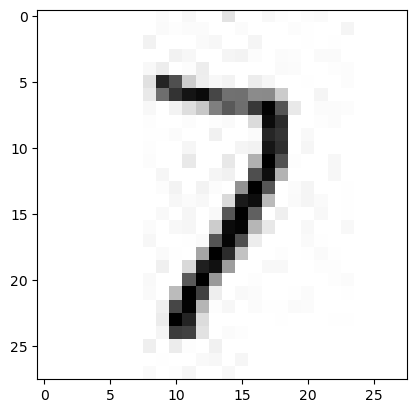

In [31]:
img = cv.imread('Images/8.jpeg', 0)
plot(img)

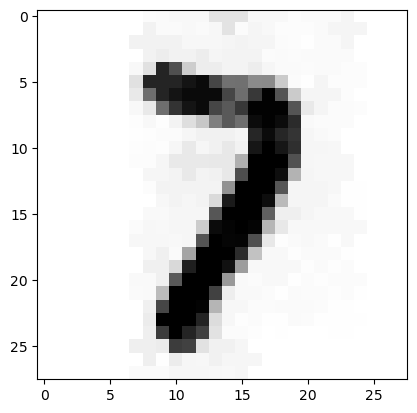

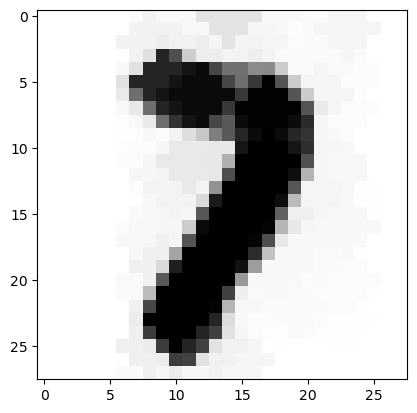

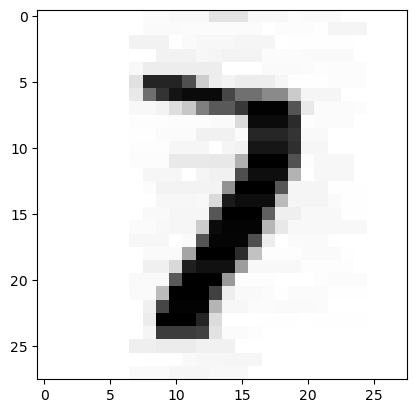

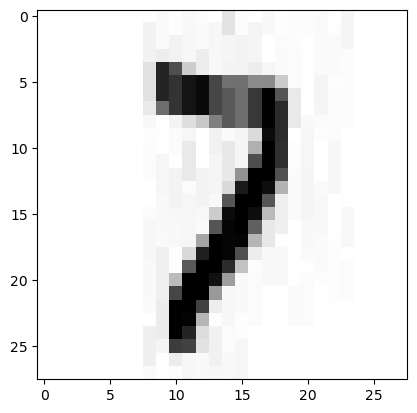

In [32]:
processed_img = [
    dilation(img, structure=Structure.s3x3),
    dilation(img, structure=Structure.s5x5),
    dilation(img, structure=Structure.s1x3),
    dilation(img, structure=Structure.s3x1),
]
plot(processed_img[0])
plot(processed_img[1])
plot(processed_img[2])
plot(processed_img[3])

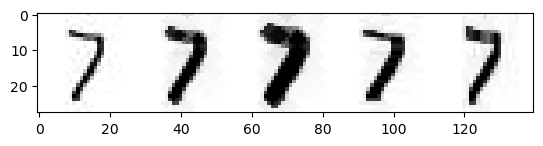

In [36]:
"""
1st image: Original
2nd image: 3x3 structure
3rd image: 5x5 structure
4th image: 1x3 structure
5th image: 3x1 structure
"""

plot_multiple([img] + processed_img)

Se puede observar de este modo que la transformación de dilatacion expande el tamaño del objeto y dependiendo de la estructura utilizada se puede dilatar solo en una dirección o bien se puede alterar la intensidad de la transformación.